In [2]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import manipulate_text as mt

In [3]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def find_circular_rings(THETA, th_range):
    ind = np.where(np.logical_or(THETA<th_range[0], THETA>th_range[1]))
    return ind

#puts indices in decending order with respect to a certain axis
def sort_ind(ind, axis=0):
    p = ind[0].argsort()[::-1]
    new_ind = ()
    for elem in ind:
        new_ind += (elem[p],)
    return new_ind

def mask_image(image, ind , sort=True):
    sh = image.shape
    #reshape image if neccessary 
    if not len(sh) == 3:
        n = sh[0]
        N = sh[1]
        block_image = np.transpose(image).reshape(N,n)
    else:
        block_image = image

    #convert block_image to a list of arrays
    block_image_ls = list(block_image)
    
    #sort indices if neccesary
    if sort:
        #reorder ind
        ind = sort_ind(ind)
    
    #remove entries
    for i in range(len(ind[0])):
        block_image_ls[ind[1][i]] = np.delete(block_image_ls[ind[1][i]], ind[0][i], 0)
    
    return block_image_ls

#coords = (x, y)                                                                                                                                               
#ellipse_params = (r2, a, thickness/2)                                                                                                                         
def create_mask(THETA, th_range, coords=None, ellipse_params=None, data=None,  sigma_rms=None, num_sigma_rms=None, sigma_BW=None, num_sigma_BW=None, dlt=None,\
 method='azimuthally_sym'):
    if method=='azimuthally_sym':
        return np.logical_and(THETA>th_range[0], THETA<th_range[1])
    elif method=='ellipse_and_azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+ellipse_params[0]*coords[1]**2)
        m2 = np.abs(elliptic_d-ellipse_params[1])>ellipse_params[2]
        return m1*m2
    
def make_spot(x, w_spot):
    template = w_spot[2]*np.exp(-((x[0]-w_spot[0])**2+(x[1]-w_spot[1])**2)/(2*w_spot[3]**2))
    return template
    
def f(x, w):
    spot_params = w[5:]
    spot_ls = [[spot_params[4*i0 + i] for i in range(4)] for i0 in range(int(len(spot_params)/4))]
    spot_temp = 0*x[0]
    for item in spot_ls:
        spot_temp += make_spot(x, item)
    elliptic_d = np.sqrt(x[0]**2+w[2]*x[1]**2)
    ell_unif = w[0]+w[1]*np.exp(-(elliptic_d-w[3])**2/(2*w[4]))
    return ell_unif+spot_temp

def im_to_1d(image, kind='list'):
    if kind=='list':
        image_t = tuple(image)
    res = np.hstack(image_t)
    return res

#args = (data, x, sigma, mask)
def chi2(w, *args):
    model = f(args[1], w)
    return np.sum(((args[0]-model)**2/args[2]**2)*args[3])

def remove_ps(data, args):
    pass

In [4]:
#define relevant paths and names
base_path = os.getcwd().split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'

In [5]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')

real data info extracted


In [6]:
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
sigma_rms = [0.25, 0.3]
l = 2/3
b = 2/3
outside = np.logical_or(np.abs(AX_N)>(l/2)*np.pi/180, np.abs(AX_n)>(b/2)*np.pi/180)
inside = np.logical_not(outside)
noise = sigma_rms[-1]*outside + sigma_rms[0]*inside

In [41]:
dless_rad1 = 2
dless_rad2 = 2.5
num_sigmas = 4
ann1 = dless_rad1*HPBW/2
ann2 = dless_rad2*HPBW/2
ind0 = np.where(THETA==0)
indx0 = ind0[0][0]
indy0 = ind0[1][0]
ind_ann0 = np.where(np.logical_and(THETA>ann1, THETA<ann2))
dlt_ind_ann = (ind_ann0[0]-indx0, ind_ann0[1]-indy0)

N_cent = 3
n_cent = 3
ind0_centx = int((N_cent-1)/2)
ind0_centy = int((n_cent-1)/2)
z_mat = np.zeros((N_cent, n_cent))
ind_cent0 = np.where(z_mat>-1)
dlt_ind_cent = (ind_cent0[0]-ind0_centx, ind_cent0[1]-ind0_centy)

In [8]:
print(dlt_ind_ann)


(array([-4, -4, -4, -4, -4, -3, -3, -3, -3, -3, -3, -3, -2, -2, -2, -2, -1,
       -1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4]), array([-2, -1,  0,  1,  2, -3, -2, -1,  0,  1,  2,  3, -4, -3,  3,  4, -4,
       -3,  3,  4, -4, -3,  3,  4, -4, -3,  3,  4, -4, -3,  3,  4, -3, -2,
       -1,  0,  1,  2,  3, -2, -1,  0,  1,  2]))


i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  30
i:  31
i:  32
i:  33
i:  34
i:  35
i:  36
i:  37
i:  38
i:  39
i:  40
i:  41
i:  42
i:  43
i:  44
i:  45
i:  46
i:  47
i:  48
i:  49
i:  50
i:  51
i:  52
i:  53
i:  54
i:  55
i:  56
i:  57
i:  58
i:  59
i:  60
i:  61
i:  62
i:  63
i:  64
i:  65
i:  66
i:  67
i:  68
i:  69
i:  70
i:  71
i:  72
i:  73
i:  74
i:  75
i:  76
i:  77
i:  78
i:  79
i:  80
i:  81
i:  82
i:  83
i:  84
i:  85
i:  86
i:  87
i:  88
i:  89
i:  90
i:  91
i:  92
i:  93
i:  94
i:  95
i:  96
i:  97
i:  98
i:  99
i:  100
i:  101
i:  102
i:  103
i:  104
i:  105
i:  106
i:  107
i:  108
i:  109
i:  110
i:  111
i:  112
i:  113
i:  114
i:  115
i:  116
i:  117
i:  118
i:  119
i:  120
i:  121
i:  122
i:  123
i:  124
i:  125
i:  126
i:  127
i:  128
i:  129
i:  130
i:  131
i:  132
i:  133
i:  134
i:  135
i:  136
i:  137
i:  13

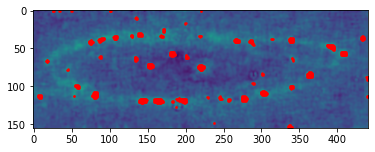

In [42]:
N_half = (N-1)/2
n_half = (n-1)/2
sh = data.shape
mask_indx = []
mask_indy = []
for i in range(sh[0]):
    print('i: ', i)
    for j in range(sh[1]):
        ind_of_ind = [k for k in range(len(dlt_ind_ann[0])) \
                              if j+dlt_ind_ann[1][k] < N and j+dlt_ind_ann[1][k] >= 0\
                             and i+dlt_ind_ann[0][k] < n and i+dlt_ind_ann[0][k] >= 0]
        ind_ann_x = np.array([int(j+dlt_ind_ann[1][ind]) for ind in ind_of_ind])
        ind_ann_y = np.array([int(i+dlt_ind_ann[0][ind]) for ind in ind_of_ind])
        num_ann = len(ind_of_ind)
        
        ind_of_ind_cent = [k for k in range(len(dlt_ind_cent[0])) \
                              if j+dlt_ind_cent[1][k] < N and j+dlt_ind_cent[1][k] >= 0\
                             and i+dlt_ind_cent[0][k] < n and i+dlt_ind_cent[0][k] >= 0]
        ind_cent_x = np.array([int(j+dlt_ind_cent[1][ind]) for ind in ind_of_ind_cent])
        ind_cent_y = np.array([int(i+dlt_ind_cent[0][ind]) for ind in ind_of_ind_cent])
        num_cent = len(ind_of_ind_cent)
        
        #compute average intensity in annulus and center
        I_center = np.sum(data[(ind_cent_y, ind_cent_x)])/num_cent
        I_ann = np.sum(data[(ind_ann_y, ind_ann_x)])/num_ann
        
        if I_center > num_sigmas*noise[i,j]+I_ann:
            mask_indy.append(i)
            mask_indx.append(j)
            
mask_inds = (np.array(mask_indy), np.array(mask_indx))

plt.imshow(data)
plt.scatter(mask_inds[1], mask_inds[0], s=2, color='r')

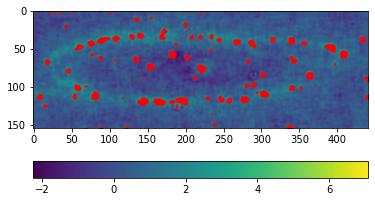

In [40]:
plt.imshow(data)
plt.colorbar(orientation='horizontal')
plt.scatter(mask_inds[1], mask_inds[0], s=1, color='r')

In [18]:
THETA[ind_ann0]

array([0.00032522, 0.00029984, 0.00029089, 0.00029984, 0.00032522,
       0.00030853, 0.0002622 , 0.00022997, 0.00021817, 0.00022997,
       0.0002622 , 0.00030853, 0.00032522, 0.0002622 , 0.0002622 ,
       0.00032522, 0.00029984, 0.00022997, 0.00022997, 0.00029984,
       0.00029089, 0.00021817, 0.00021817, 0.00029089, 0.00029984,
       0.00022997, 0.00022997, 0.00029984, 0.00032522, 0.0002622 ,
       0.0002622 , 0.00032522, 0.00030853, 0.0002622 , 0.00022997,
       0.00021817, 0.00022997, 0.0002622 , 0.00030853, 0.00032522,
       0.00029984, 0.00029089, 0.00029984, 0.00032522])